# Validation Monte Carlo SPECT

In [1]:
import os
import numpy as np
from pytomography.algorithms import OSEM
from pytomography.io.SPECT import simind
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from scipy.ndimage import zoom
import torch

Change this to where data is saved

In [2]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

Open ground truth image

In [3]:
GT = np.fromfile(os.path.join(input_path, 'spect_simind_validation', 'body1_Lu177_T2.bin'), dtype=np.float32)
GT = GT.reshape((751,512,512))
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))
GT = zoom(GT, (128/512, 128/512, 384/767), order=0, mode='nearest')
calib = 0.21089022221130554 #calibration constant from SIMIND output file

In [4]:
liver_mask = (GT>0.033)*(GT<0.034)

In [5]:
kidney_mask = (GT>0.52)*(GT<0.521) + (GT>0.504)*(GT<0.5042)

1. Reconstruct using PyTomography

In [6]:
headerfile = os.path.join(input_path, 'spect_simind_validation', 'body1t2ew6_tot_w2.hdr')
object_meta, proj_meta = simind.get_metadata(headerfile)
photopeak = simind.get_projections(headerfile)
CT = simind.get_attenuation_map(os.path.join(input_path, 'spect_simind_validation', 'body1.hct'))
att_transform = SPECTAttenuationTransform(CT)
psf_meta = simind.get_psfmeta_from_header(headerfile)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta
            )
likelihood = PoissonLogLikelihood(system_matrix, photopeak)
reconstruction_algorithm = OSEM(likelihood)
reconstructed_object = reconstruction_algorithm(n_iters=2, n_subsets=8)
reconstructed_object = reconstructed_object.cpu().numpy()

2. Open reconstructed STIR file (obtained using `OSMAPOSL recon.par` in STIR)

In [8]:
reconstructed_object_stir = np.fromfile(os.path.join(input_path, 'spect_simind_validation', 'OSEM_16.v'), dtype=np.float32)
reconstructed_object_stir = np.transpose(reconstructed_object_stir.reshape(384,128,128)[::-1,::-1,::-1], (2,1,0)) #* calib

Slices and profile indices

In [9]:
s = 64
l1 = 167
l2 = 250
l3 = 315
#delta = reconstructed_object - reconstructed_object_stir

Plotting functions

In [10]:
def plot_differences(ax,l, uppery=None, lowery=None):
    #plt.plot(GT[:,64,l], color='k', lw=2)
    stir = reconstructed_object_stir[:,64,l]
    pytomo = reconstructed_object[:,64,l]
    diff = stir - pytomo
    ax.plot(np.arange(128)*0.3,stir, marker='', ls='-', lw=1.5, color='r', label='STIR')
    ax.plot(np.arange(128)*0.3,pytomo, marker='', ls='--', lw=2.5, color='blue', label='PyTomography')
    ax.plot(np.arange(128)*0.3,diff, marker='', ls='-', lw=2.5, color='k', label='Difference', zorder=-10000)
    #ax.plot(np.arange(128)*0.3,np.abs(reconstructed_object[:,s,l]-reconstructed_object_stir[:,s,l])*100, ls='dotted', color='dimgrey', label='Difference (x100)')
    #plt.plot(delta[:,64,l])
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 5
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.5
    im = ax.pcolormesh(ob[:,64].T, cmap=cmap, vmax=vmax)
    ax.axhline(l1, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2, ls='--', color=tcol, lw=0.8)
    ax.axhline(l3, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l3+7, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2+7, '2', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l1+7, '3', ha='center', va='center', color=tcol, size=13)
    return im

Plot

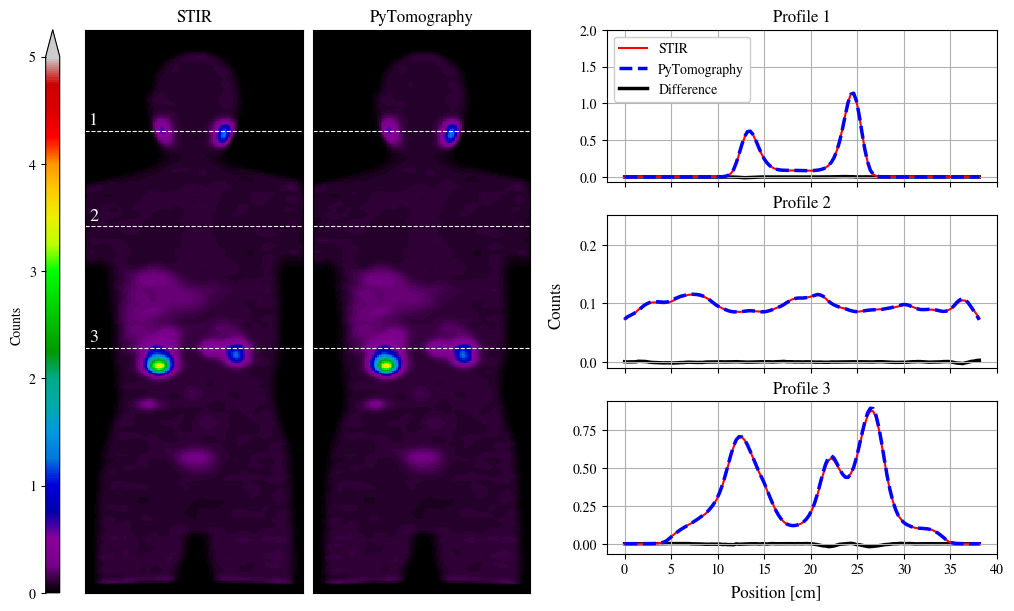

In [12]:
mode = 'color'
fig = plt.figure(constrained_layout=True, figsize=(10,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.85,0.75))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('STIR')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_stir, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object, axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Counts', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=3, ncols=1, sharex=True)
plot_differences(axes_r[0],l3)
axes_r[0].set_title('Profile 1')
axes_r[0].set_ylim(top=2)
axes_r[0].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=10)
plot_differences(axes_r[1],l2, uppery=0.25, lowery=-0.01)
axes_r[1].set_title('Profile 2')
plot_differences(axes_r[2],l1)
axes_r[2].set_title('Profile 3')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Counts')
plt.savefig('figures/figure5.jpg', dpi=300)

Statistics pertaining to liver:

In [13]:
print(f'Noise (liver): {reconstructed_object_stir[liver_mask].std()}')
print(f'Kidnies: {reconstructed_object_stir[kidney_mask].mean()}')

Noise (liver): 0.07885903120040894
Kidnies: 1.7636042833328247


In [14]:
print(f'Noise (liver): {reconstructed_object[liver_mask].std()}')
print(f'Kidnies: {reconstructed_object[kidney_mask].mean()}')

Noise (liver): 0.07931146770715714
Kidnies: 1.7612733840942383


Statistics computed in paper:

In [15]:
mask = reconstructed_object>0.05

* Maximum error

In [16]:
np.max((reconstructed_object[mask] - reconstructed_object_stir[mask]) / reconstructed_object_stir[mask] * 100)

23.597227

* RMSE

In [17]:
np.sqrt(((reconstructed_object - reconstructed_object_stir) ** 2).mean())

0.0016470838